# Investigate how network width and depths impact performance

## Main Questions

* Are two layers enough?
* Do we need wide networks?

In [67]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'mlp_learning_curve'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines/train'
bs_merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']
file_names = ['metrics.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

metrics_df = metrics_df.reset_index(drop=True)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [69]:
baseline_df

,baseline,name,value,cv_split,epoch,set,strategy
0,onehot_mlp,loss,3.086031,0,0,None,None
1,onehot_mlp,mean_absolute_error,8.987950,0,0,train,None
2,onehot_mlp,accuracy,0.035976,0,0,train,None
3,onehot_mlp,mean_absolute_error,10.737342,0,0,test,None
4,onehot_mlp,accuracy,0.031646,0,0,test,None
...,...,...,...,...,...,...,...
17995,onehot_mlp_graph_2,accuracy,0.351380,19,990,train,sampling
17996,onehot_mlp_graph_2,mean_absolute_error,3.013699,19,990,test,greedy
17997,onehot_mlp_graph_2,accuracy,0.479452,19,990,test,greedy
17998,onehot_mlp_graph_2,mean_absolute_error,3.876712,19,990,test,sampling


In [70]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size', 'batch_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    # synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    # confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['batch_size', 'fraction_training', 'regularisation', 'hidden_size', 'strategy', 'lr']


In [71]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990) & 
    (baseline_df['strategy'] == 'greedy') & 
    (baseline_df['baseline'] == 'onehot_mlp_graph_2') 
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline            name               
onehot_mlp_graph_2  accuracy               0.489726
                    mean_absolute_error    2.867874
Name: value, dtype: float64

In [72]:
metrics_df.head()

,batch_size,fraction_training,hidden_size,lr,regularisation,name,value,cv_split,epoch,set,strategy,label
0,20,1.0,5,1.e-4,wd_1.e-6,loss,3.094353,0,0,None,None,batch_size:20 fraction_training:1.0 regularisa...
1,20,1.0,5,1.e-4,wd_1.e-6,mean_absolute_error,12.592036,0,0,train,greedy,batch_size:20 fraction_training:1.0 regularisa...
2,20,1.0,5,1.e-4,wd_1.e-6,accuracy,0.027325,0,0,train,greedy,batch_size:20 fraction_training:1.0 regularisa...
3,20,1.0,5,1.e-4,wd_1.e-6,mean_absolute_error,8.127092,0,0,train,sampling,batch_size:20 fraction_training:1.0 regularisa...
4,20,1.0,5,1.e-4,wd_1.e-6,accuracy,0.054649,0,0,train,sampling,batch_size:20 fraction_training:1.0 regularisa...


## Overview

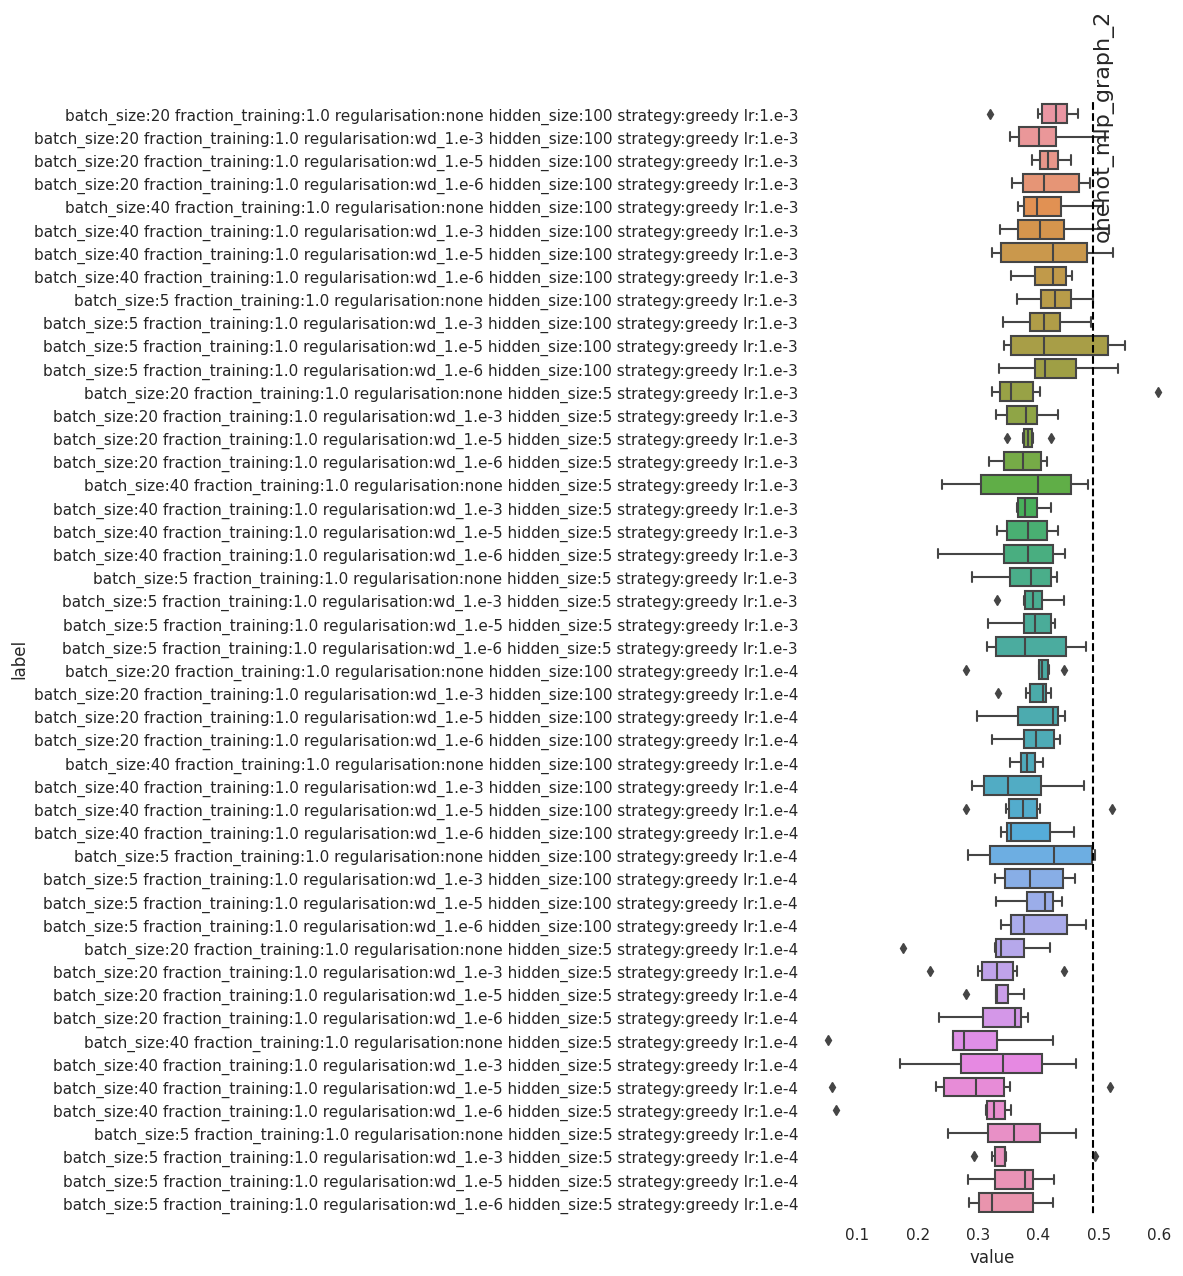

In [73]:
metric_name = 'accuracy'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['fraction_training'] == 1) & 
    (metrics_df['epoch'] == 990)
)

w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(['lr', 'hidden_size', 'batch_size', 'regularisation'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

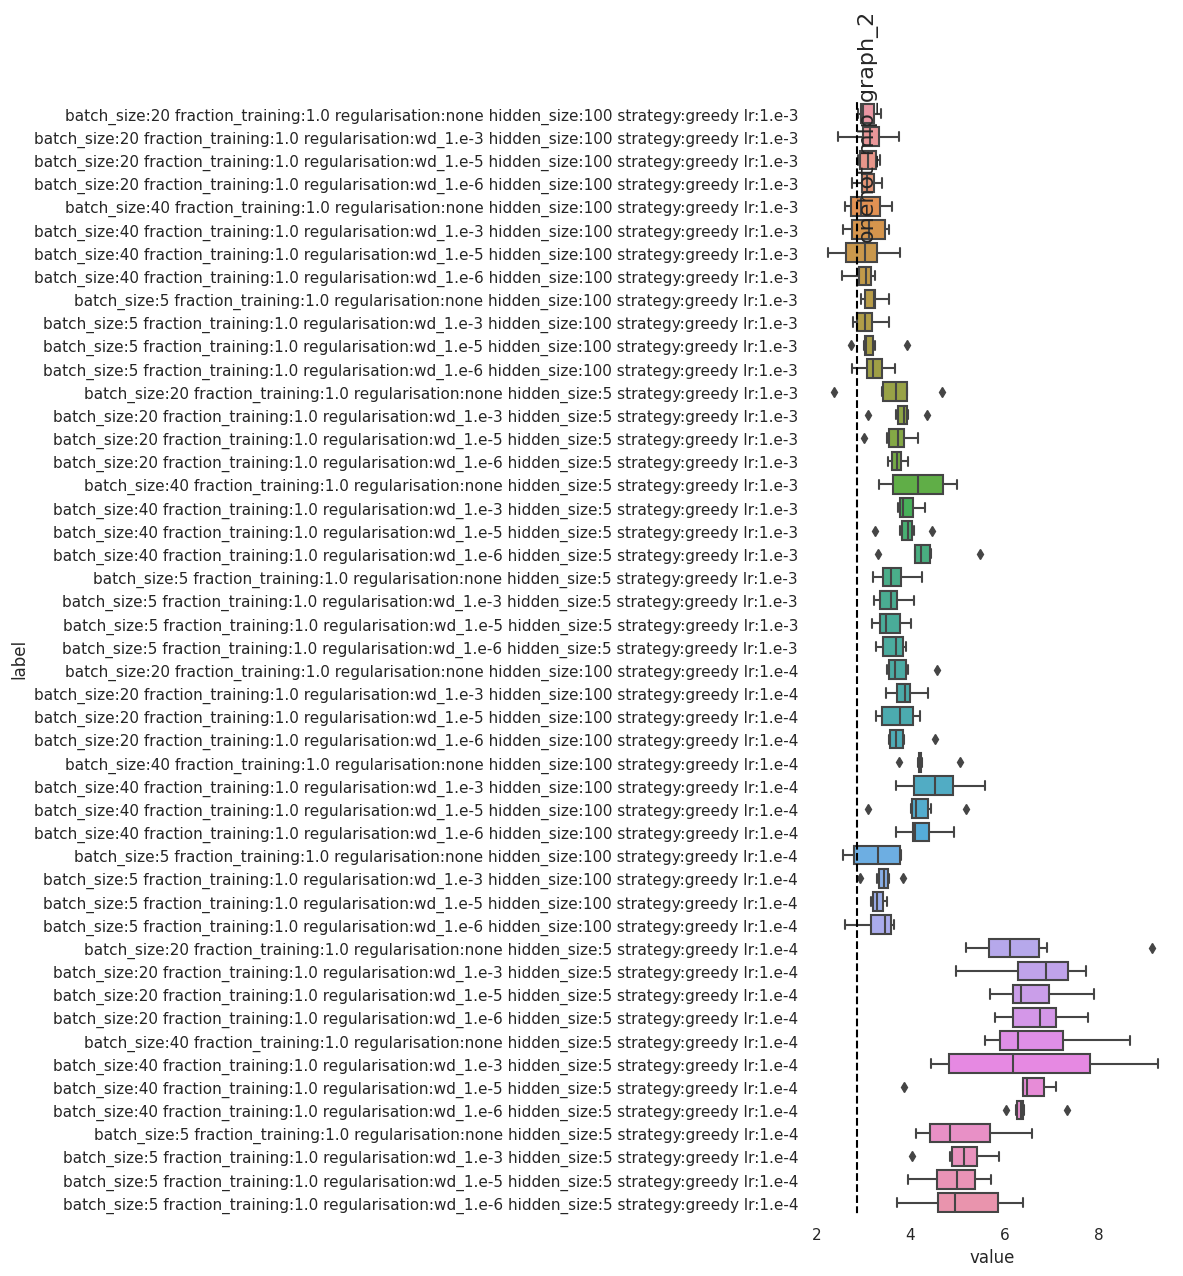

In [74]:
metric_name = 'mean_absolute_error'
w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(['lr', 'hidden_size', 'batch_size', 'regularisation'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

In [75]:
df.head()

,batch_size,fraction_training,hidden_size,lr,regularisation,name,value,cv_split,epoch,set,strategy,label
314096,20,1.0,100,1.e-3,none,mean_absolute_error,3.366834,0,990,test,greedy,batch_size:20 fraction_training:1.0 regularisa...
314996,20,1.0,100,1.e-3,none,mean_absolute_error,2.961290,1,990,test,greedy,batch_size:20 fraction_training:1.0 regularisa...
315896,20,1.0,100,1.e-3,none,mean_absolute_error,3.297075,2,990,test,greedy,batch_size:20 fraction_training:1.0 regularisa...
316796,20,1.0,100,1.e-3,none,mean_absolute_error,3.044444,3,990,test,greedy,batch_size:20 fraction_training:1.0 regularisa...
317696,20,1.0,100,1.e-3,none,mean_absolute_error,2.939481,4,990,test,greedy,batch_size:20 fraction_training:1.0 regularisa...


### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [76]:
label_ref = {
    # 'fraction_training': 1,
    'batch_size': '5',
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [94]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
# results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')

results_df[results_df['P>|z|'] < 0.10].sort_values('Coef.')

metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
"C(batch_size, Treatment(reference='5'))[T.40]",-0.080586,0.014790,-5.448826,5.070326e-08,-0.109573,-0.051599
"C(batch_size, Treatment(reference='5'))[T.20]",-0.047915,0.014790,-3.239787,1.196190e-03,-0.076902,-0.018928
"fraction_training:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.034512,0.013163,-2.621830,8.745913e-03,-0.060312,-0.008712
"C(hidden_size, Treatment(reference='5'))[T.100]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.032446,0.007455,-4.352118,1.348286e-05,-0.047057,-0.017834
"fraction_training:C(hidden_size, Treatment(reference='5'))[T.100]",-0.024218,0.013163,-1.839826,6.579381e-02,-0.050018,0.001581
"C(batch_size, Treatment(reference='5'))[T.20]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.016348,0.009141,1.788358,7.371828e-02,-0.001569,0.034265
"C(batch_size, Treatment(reference='5'))[T.40]:C(hidden_size, Treatment(reference='5'))[T.100]",0.022360,0.009141,2.445997,1.444522e-02,0.004443,0.040277
"C(batch_size, Treatment(reference='5'))[T.40]:fraction_training",0.030956,0.016131,1.918996,5.498478e-02,-0.000661,0.062573
"C(batch_size, Treatment(reference='5'))[T.20]:fraction_training",0.031313,0.016131,1.941115,5.224429e-02,-0.000304,0.062929
"C(batch_size, Treatment(reference='5'))[T.40]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.032645,0.009141,3.571182,3.553738e-04,0.014729,0.050562


In [78]:
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.294703,0.014524,20.290138,1.571541e-91,0.266236,0.323171
"C(batch_size, Treatment(reference='5'))[T.20]",-0.047915,0.014790,-3.239787,1.196190e-03,-0.076902,-0.018928
"C(batch_size, Treatment(reference='5'))[T.40]",-0.080586,0.014790,-5.448826,5.070326e-08,-0.109573,-0.051599
"C(regularisation, Treatment(reference='none'))[T.wd_1.e-3]",-0.011658,0.016228,-0.718421,4.724975e-01,-0.043464,0.020148
"C(regularisation, Treatment(reference='none'))[T.wd_1.e-5]",-0.011754,0.016228,-0.724307,4.688772e-01,-0.043560,0.020052
"C(regularisation, Treatment(reference='none'))[T.wd_1.e-6]",0.005615,0.016228,0.346035,7.293161e-01,-0.026191,0.037421
"C(hidden_size, Treatment(reference='5'))[T.100]",0.071920,0.012643,5.688635,1.280589e-08,0.047140,0.096699
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.068857,0.012689,5.426396,5.750339e-08,0.043986,0.093728
"C(batch_size, Treatment(reference='5'))[T.20]:C(regularisation, Treatment(reference='none'))[T.wd_1.e-3]",0.005508,0.012973,0.424553,6.711625e-01,-0.019919,0.030935
"C(batch_size, Treatment(reference='5'))[T.40]:C(regularisation, Treatment(reference='none'))[T.wd_1.e-3]",0.004030,0.012973,0.310598,7.561065e-01,-0.021398,0.029457


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [95]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'sampling') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('Coef.')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-1.929017,0.067057,-28.766822,5.580251e-182,-2.060446,-1.797588
"C(hidden_size, Treatment(reference='5'))[T.100]",-1.899032,0.066811,-28.423982,1.022169e-177,-2.029979,-1.768085
fraction_training,-1.319457,0.098782,-13.357253,1.074576e-40,-1.513067,-1.125848
"C(batch_size, Treatment(reference='5'))[T.40]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.715491,0.048308,-14.811045,1.242936e-49,-0.810173,-0.620810
"C(batch_size, Treatment(reference='5'))[T.20]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.536602,0.048308,-11.107932,1.147866e-28,-0.631284,-0.441920
"C(batch_size, Treatment(reference='5'))[T.40]:C(hidden_size, Treatment(reference='5'))[T.100]",-0.516269,0.048308,-10.687033,1.170565e-26,-0.610951,-0.421587
"C(batch_size, Treatment(reference='5'))[T.20]:C(hidden_size, Treatment(reference='5'))[T.100]",-0.405608,0.048308,-8.396291,4.608041e-17,-0.500290,-0.310926
"C(batch_size, Treatment(reference='5'))[T.20]:fraction_training",-0.226184,0.085246,-2.653299,7.970926e-03,-0.393264,-0.059104
"C(regularisation, Treatment(reference='none'))[T.wd_1.e-3]:C(hidden_size, Treatment(reference='5'))[T.100]",0.117624,0.055847,2.106198,3.518717e-02,0.008167,0.227082
"fraction_training:C(hidden_size, Treatment(reference='5'))[T.100]",0.451757,0.069562,6.494283,8.342960e-11,0.315418,0.588097


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [80]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is batch_size:40 fraction_training:0.8 regularisation:none hidden_size:100 strategy:greedy lr:1.e-3.
                       name    set     value
102796             accuracy   test  0.441553
102797  mean_absolute_error   test  3.050689
102798             accuracy  train  0.418284
102799  mean_absolute_error  train  3.014722
Best performance for metric accuracy is batch_size:5 fraction_training:0.8 regularisation:wd_1.e-6 hidden_size:100 strategy:greedy lr:1.e-3.
                       name    set     value
175596             accuracy   test  0.447813
175597  mean_absolute_error   test  3.185381
175598             accuracy  train  0.441689
175599  mean_absolute_error  train  3.154557


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

batch_size=40|fraction_training=0.8|regularisation=none|strategy=greedy|epoch=990


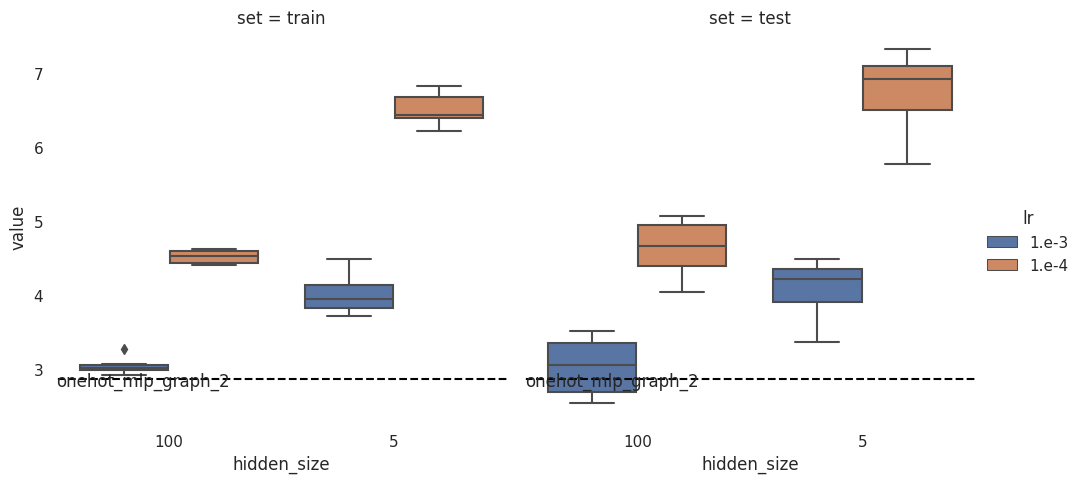

In [82]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['hidden_size', 'lr']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

batch_size=5|regularisation=wd_1.e-6|hidden_size=100|strategy=greedy|epoch=990


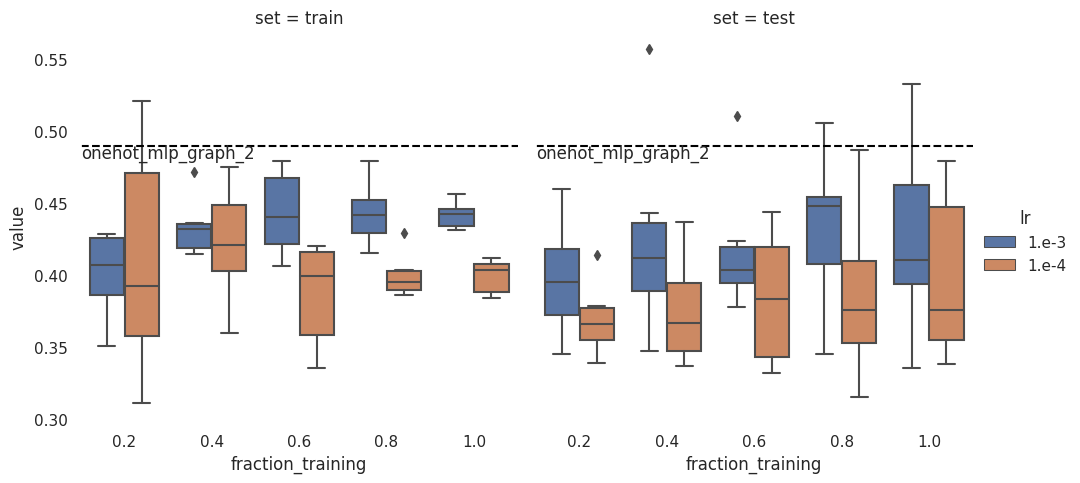

In [83]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['fraction_training', 'lr']


for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

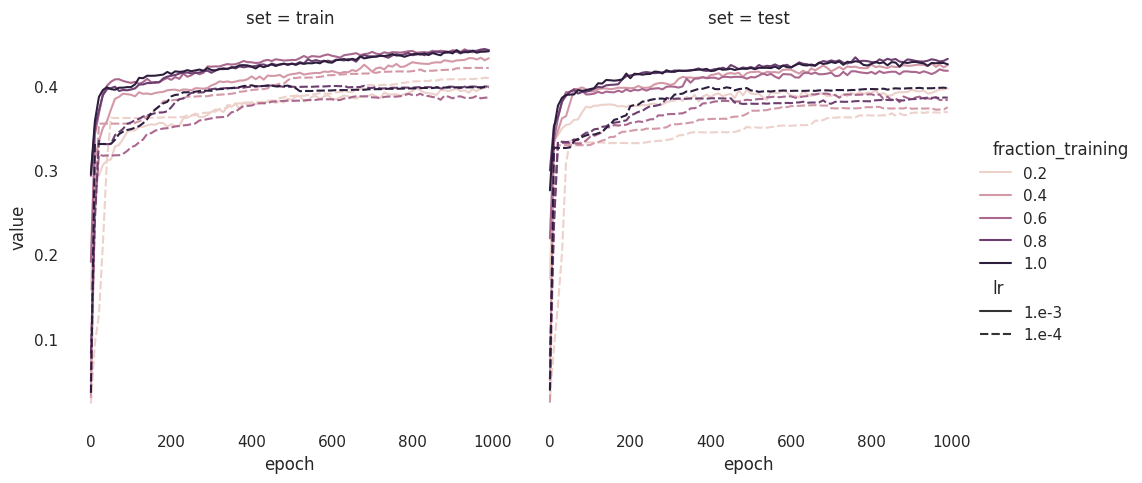

In [87]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['fraction_training','lr']



for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1], y='value', col='set', kind='line', ci=None)

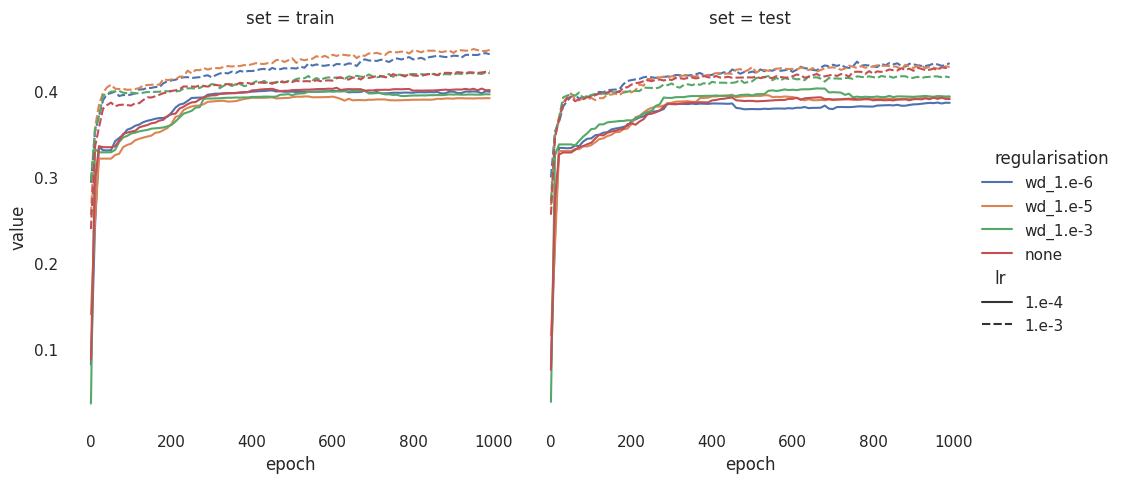

In [96]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['regularisation', 'lr']



for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) == 2 else None, y='value', col='set', kind='line', ci=None)

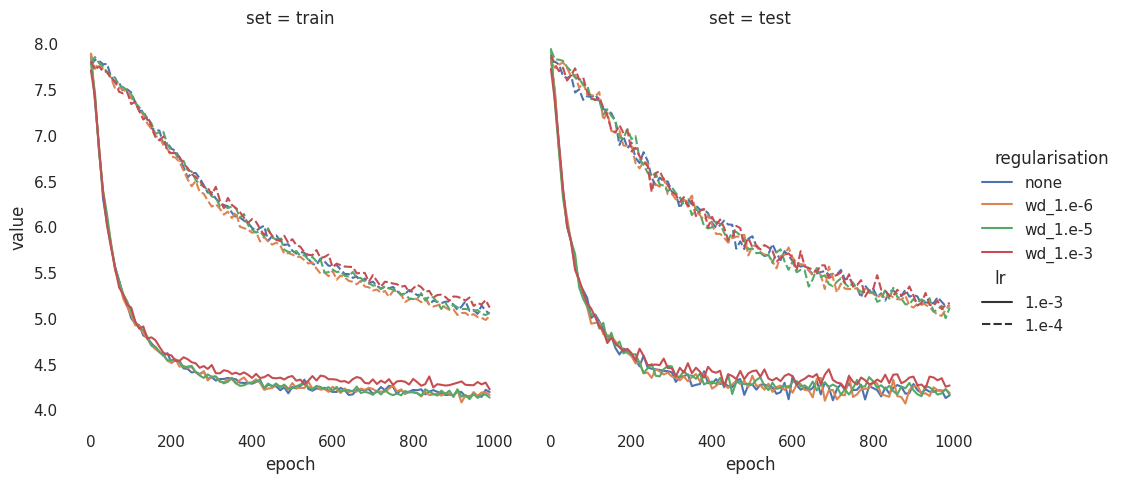

In [98]:
metric_name = 'mean_absolute_error'

selection = best_labels[metric_name].copy()

focus = ['regularisation', 'lr']



for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0
selection['strategy'] = 'sampling'


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) == 2 else None, y='value', col='set', kind='line', ci=None)